In [1]:
# !pip install tqdm

# Imports

In [2]:
import crTemplateCorrelator
import crArtificialTemplateBank
import numpy as np
from tensorflow import keras
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("analyze.py"))))
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import numpy as np
import NuRadioReco.framework.event
import NuRadioReco.framework.station
import NuRadioReco.framework.channel
from NuRadioReco.utilities import units
import logging
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("analyze.py"))))
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing
import analyze

2022-10-11 14:14:59.191210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 14:14:59.403875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 14:14:59.403903: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-11 14:14:59.439511: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 14:15:00.430721: W tensorflow/stream_executor/pla

# Real and generated data

In [3]:
# Load data
data = np.load('../data_preprocessed_512.npy')
current_noise = np.load('../current_noise.npy')

In [4]:
print(np.shape(data))
print(np.shape(current_noise[0:9157,:]))
current_noise = current_noise[0:9157,:]

(9157, 512)
(9157, 512)


In [5]:
print(np.shape(current_noise))

print(data.mean())
print(data.std())

(9157, 512)
-1.4336996031661545e-17
1.0000000000000002


In [6]:
# Load generator
generator = keras.models.load_model('../kapre_lstm_generator_4/') 


2022-10-11 14:15:02.194928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-11 14:15:02.195078: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-11 14:15:02.195113: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wgs3e.zeuthen.desy.de): /proc/driver/nvidia/version does not exist
2022-10-11 14:15:02.195592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
noise = np.random.randn(len(data), 128)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = generator.predict_on_batch(noise)
generated_signals = generated_signals[:,:,0]

print(np.shape(generated_signals))

(9157, 512)


In [8]:
print(generated_signals.mean())
print(generated_signals.std())

0.05111991
0.9981227


In [9]:
station_number = 24
channels = [0]


def get_nuradiomc_event(trace, run_number=1, event_number=1):
        evt = NuRadioReco.framework.event.Event(run_number, event_number)
        station = NuRadioReco.framework.station.Station(station_number)
        
        # Loop over all requested channels in data
        for chan in channels:
            channel = NuRadioReco.framework.channel.Channel(chan)

            # Get data GAN
            trace = trace
            channel.set_trace(trace, 3.2*units.GHz)
            station.add_channel(channel)
            
        evt.set_station(station)
        return evt

In [10]:
events_gen = []
events_data = []
events_current = []
for i, trace in enumerate(generated_signals):
    event = get_nuradiomc_event(trace, 1, i)
    events_gen.append(event)

for i, trace in enumerate(data):
    event = get_nuradiomc_event(trace, 1, i)
    events_data.append(event)

for i, trace in enumerate(current_noise):
    event = get_nuradiomc_event(trace, 1, i)
    events_current.append(event)

In [11]:
print(len(events_gen))

9157


# Template correlation

## Create templates

In [12]:
crArtificialTemplateBank = crArtificialTemplateBank.crArtificialTemplateBank()
crArtificialTemplateBank.begin(detector_file='RNO_G_LPDAs.json', logger_level=logging.ERROR)
crArtificialTemplateBank.set_parameter_templates(0, Efield_width=[5,4,2])

In [13]:
templates = crArtificialTemplateBank.get_templates()

## Create template correlator

In [14]:
crTemplateCorrelator = crTemplateCorrelator.crTemplateCorrelator()

## Correlation

In [15]:
# Settings for correlation
channel_num_data = channels[0]
station_num_data = station_number

### Generator

In [16]:
max_corr_lst_gen = []
# Loop over all events
for event in events_gen:
    corr = []
    # Loop over the three templates
    for template in templates:
        
        # Get statation and channel number for template
        station_num_temp = template.get_station_ids()[0]
        station = template.get_station(station_num_temp)
        channel_num_temp = station.get_channel_ids()[0]
        
        # Calculate maximum correlation for this template and add to corr list
        corr.append(max(crTemplateCorrelator.correlation_scan_single_spacing_matrix_variable_window(event, template, channel_num_data, channel_num_temp, station_num_data, station_num_temp, 200 * units.nanosecond, return_time_difference=False,showPlot=False)))
    
    # Add the maximum correlation for the three templates in to list
    max_corr_lst_gen.append(max(corr))
    
    
    

In [17]:
print(len(max_corr_lst_gen))

9157


### Data

In [18]:
max_corr_lst_data = []
# Loop over all events
for event in events_data:
    corr = []
    # Loop over the three templates
    for template in templates:
        
        # Get statation and channel number for template
        station_num_temp = template.get_station_ids()[0]
        station = template.get_station(station_num_temp)
        channel_num_temp = station.get_channel_ids()[0]
        
        # Calculate maximum correlation for this template and add to corr list
        corr.append(max(crTemplateCorrelator.correlation_scan_single_spacing_matrix_variable_window(event, template, channel_num_data, channel_num_temp, station_num_data, station_num_temp, 200 * units.nanosecond, return_time_difference=False,showPlot=False)))
    
    # Add the maximum correlation for the three templates in to list
    max_corr_lst_data.append(max(corr))

# Current noise

In [19]:
max_corr_lst_current = []
# Loop over all events
for event in events_current:
    corr = []
    # Loop over the three templates
    for template in templates:
        
        # Get statation and channel number for template
        station_num_temp = template.get_station_ids()[0]
        station = template.get_station(station_num_temp)
        channel_num_temp = station.get_channel_ids()[0]
        
        # Calculate maximum correlation for this template and add to corr list
        corr.append(max(crTemplateCorrelator.correlation_scan_single_spacing_matrix_variable_window(event, template, channel_num_data, channel_num_temp, station_num_data, station_num_temp, 200 * units.nanosecond, return_time_difference=False,showPlot=False)))
    
    # Add the maximum correlation for the three templates in to list
    max_corr_lst_current.append(max(corr))

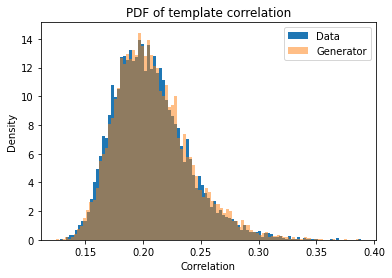

In [22]:
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_size_inches(12, 6, forward=True)
# bins = 100

# ax1.hist(max_corr_lst_data, bins=bins, label = "Data")
# ax1.hist(max_corr_lst_gen, alpha=0.5,  bins=bins, label = "Generator")
# # ax1.hist(max_corr_lst_current, alpha=0.5,  bins=bins, label = "Current noise")
# ax1.legend()
# ax1.set_title("Histogram of data and generated data")
bins = 100
plt.hist(max_corr_lst_data, bins=bins, label = "Data", density=True)
plt.hist(max_corr_lst_gen, alpha=0.5,  bins=bins, label = "Generator", density=True)
# plt.hist(max_corr_lst_current, alpha=0.5,  bins=bins, label = "Current noise", density=True)
plt.legend()
plt.title("PDF of template correlation")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.show()